# Handout 08
#### Sara Díaz del Ser


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np
import diazdelser_fastatools as fa

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")



plt.style.use('dark_background')

In [2]:
# Files
insensitive_file = './data/exosome-insensitive.fa'
sensitive_file= './data/exosome-sensitive.fa'

### Ex. 1 _(20 pts)_ K-Mer Distributions

#### (a) _(5 pts)_ Write a function ```kmer_frequencies(seqs,k)```
that takes a set of $m$ RNA sequences seqs and a parameter k as input and returns the relative frequencies for all
k-mers contained in the sequences as a dictionary. Note, that each sequence of length $n$ contains $n$ - $k$ + 1 k-mers.

For the calculation of relative frequencies use pseudocounts. That is, the frequency of
each k-mer is increased by 1, regardless whether it occurs in the sequences or not.

In [3]:
def kmer_frequencies(seq:str,k:int) -> dict:
	"""Takes a sequence and a parameter k and returns the relative frequencies for all k-mers"""
	# Generate dict of possible kmers
	kmers = { "".join(kmer) : 1 for kmer in it.product(['A','G','T','C'], repeat=k) }

	# Count each kmer
	for i in range(0,len(seq)-k+1):
		kmers[seq[i:i+k]] = kmers.get(seq[i:i+k], 1) + 1

	# Observed relative freq
	return { key: val/sum(kmers.values()) for key, val in kmers.items()}

def sum_dict(d1,d2):
	"""Sum two dictionaries"""
	return { key : d1[key] + d2[key] for key in d1.keys()}

def kmer_freq_wrapper(seqs:list, k:int) -> dict:
	"""Takes a set of RNA sequences and a parameter k and returns the relative frequencies for all k-mers"""
	kmers=kmer_frequencies(seqs[0],k)
	for i in range(1,len(seqs)-1):
		kmers = sum_dict(kmers, kmer_frequencies(seqs[i],k))
	return kmers

In [4]:
# Example
kmer_freq_wrapper(['GATGCGTAATGGATTCGATGCATGCGGCGTGAACTAGTCTAACG'],2)

{'AA': 0.06779661016949153,
 'AG': 0.03389830508474576,
 'AT': 0.1016949152542373,
 'AC': 0.05084745762711865,
 'GA': 0.0847457627118644,
 'GG': 0.05084745762711865,
 'GT': 0.06779661016949153,
 'GC': 0.0847457627118644,
 'TA': 0.06779661016949153,
 'TG': 0.1016949152542373,
 'TT': 0.03389830508474576,
 'TC': 0.05084745762711865,
 'CA': 0.03389830508474576,
 'CG': 0.1016949152542373,
 'CT': 0.05084745762711865,
 'CC': 0.01694915254237288}

#### (b) _(6 pts)_
To determine whether a certain k-mer is over- or under-represented one needs
to determine the background frequencies of individual nucleotides. If you solved the
previous exercise properly, the background frequencies for a set of sequences seqs can
be obtained form the call ```kmer_frequencies(seqs,1)```.

Similar to the calculations of the BLOSUM scoring matrix odds-ratios can be calculated
for the k-mers.


In [5]:
# Example
seq = 'GATGCGTAATGGATTCGATGCATGCGGCGTGAACTAGTCTAACG'
kmer_frequencies(seq,1)

{'A': 0.25, 'G': 0.3125, 'T': 0.25, 'C': 0.1875}

Write a function ```log_odds_ratio(observed,background)``` that takes as argument a
dictionary of observed frequencies of k-mers and a dictionary containing the background
frequencies of the individual nucleotides and calculates the log-odds ratio.

In [6]:
def expected_relf(background:dict, kmer:str) -> float:
	"""Takes a sequence and returns the expected relative frequency for all k-mers"""
	# Observed relative freq of each nucleotide
	return np.product([background[nt] for nt in kmer ])

def log_odds_ratio(observed:dict, background:dict) -> dict:
	"""Takes a sequence and returns the log_odd_ratio for all k-mers"""
	return { key : np.log2(observed[key]/expected_relf(background,key)) for key in observed.keys() }

In [7]:
# Example
seq = 'GATGCGTAATGGATTCGATGCATGCGGCGTGAACTAGTCTAACG'
observed = kmer_frequencies(seq,2)
background =  kmer_frequencies(seq,1)
log_odds_ratio(observed, background)

{'AA': 0.11735695063815874,
 'AG': -1.2045711442492038,
 'AT': 0.7023194513593151,
 'AC': 0.11735695063815874,
 'GA': 0.11735695063815874,
 'GG': -0.9415367384154097,
 'GT': -0.20457114424920364,
 'GC': 0.5323944499170026,
 'TA': 0.11735695063815874,
 'TG': 0.3803913564719527,
 'TT': -0.8826430493618412,
 'TC': 0.11735695063815874,
 'CA': -0.4676055500829974,
 'CG': 0.7954288557507966,
 'CT': 0.11735695063815874,
 'CC': -1.0525680508041537}

In [8]:
# Example
log_odds_ratio(kmer_frequencies(seq,2), kmer_frequencies(seq,1))

{'AA': 0.11735695063815874,
 'AG': -1.2045711442492038,
 'AT': 0.7023194513593151,
 'AC': 0.11735695063815874,
 'GA': 0.11735695063815874,
 'GG': -0.9415367384154097,
 'GT': -0.20457114424920364,
 'GC': 0.5323944499170026,
 'TA': 0.11735695063815874,
 'TG': 0.3803913564719527,
 'TT': -0.8826430493618412,
 'TC': 0.11735695063815874,
 'CA': -0.4676055500829974,
 'CG': 0.7954288557507966,
 'CT': 0.11735695063815874,
 'CC': -1.0525680508041537}

#### (c) _(3 pts)_ For the given data exosome-sensitive.fa and exosome-insensitive.fa calculate:
Perform these calculations for k = 2; 3; and 4.

i. The background frequencies of the nucleotides using the combined set of sequences.

In [9]:
def extract_seqs(files:list) -> list:
	"""Extract all sequences from all files and return a flat list"""
	all_sequences = []
	for file in files:
		with open(file) as f:
			_ ,sequences  = zip(*fa.all_fasta_sequences(f))
			all_sequences.extend(sequences)
	return all_sequences

In [11]:
background = []
for k in [2,3,4]:
	all_seqs = extract_seqs([insensitive_file, sensitive_file])
	background.append(kmer_freq_wrapper(all_seqs,1))

# Background frequencies are the same regardless of k
background_df = pd.DataFrame(background, index=[2,3,4])
print(background_df)

            A           G           T           C
2  215.547809  287.071713  231.260956  265.119522
3  215.547809  287.071713  231.260956  265.119522
4  215.547809  287.071713  231.260956  265.119522


ii. The observed frequencies of k-mers for a) the sensitive sequences and b) the insen-
sitive sequences


In [12]:
sensitive_seqs = extract_seqs([sensitive_file])
insensitive_seqs = extract_seqs([insensitive_file])

results = []
# Calculate observed freqs for each k
for k in [2,3,4]:
	sensitive = (kmer_freq_wrapper(sensitive_seqs, k))
	insensitive = (kmer_freq_wrapper(insensitive_seqs, k))

	# Create DataFrame
	df = pd.DataFrame([sensitive,insensitive], index=['sensitive', 'insensitive'])
	results.append(df.T)
	print(f"k={k}\n",df.T,"\n")


k=2
     sensitive  insensitive
AA  36.992118    22.187192
AG  35.414778    35.266010
AT  24.949754    16.517241
AC  23.975369    20.431527
GA  30.797044    30.934975
GG  39.874877    54.964532
GT  25.996059    26.471921
GC  33.147783    44.137931
TA  22.545813    14.567488
TG  34.175369    34.967488
TT  38.476847    28.342857
TC  28.970443    29.229557
CA  31.052217    26.765517
CG  20.320197    31.262069
CT  34.785222    35.804926
CC  37.526108    47.148768 

k=3
      sensitive  insensitive
AAA  13.723164     6.611111
AAG   8.509416     7.095104
AAT   8.125235     4.431262
AAC   6.359699     4.446328
AGA   9.257062     7.678908
..         ...          ...
CTC   9.690207    10.532015
CCA   9.013183     8.471751
CCG   6.532015    11.082863
CCT  10.500000    11.799435
CCC  11.198682    15.084746

[64 rows x 2 columns] 

k=4
       sensitive  insensitive
AAAA   4.875499     2.055866
AAAG   2.756584     1.829210
AAAT   2.938547     1.525938
AAAC   2.234637     1.380686
AAGA   2.370311   

iii. Using the common background frequency calculate the log-odds ratio for the set of
sensitive and insensitve sequences

In [24]:
sensitive_seqs = extract_seqs([sensitive_file])
insensitive_seqs = extract_seqs([insensitive_file])

results = []
# Calculate observed freqs for each k
for k in [2,3,4]:

	sensitive = log_odds_ratio(kmer_frequencies(sensitive_seqs[0],k), background[0])
	for i in range(1,len(sensitive)-1):
		sensitive = sum_dict(sensitive, log_odds_ratio(kmer_frequencies(sensitive_seqs[i],k), background[0]))

	insensitive = log_odds_ratio(kmer_frequencies(insensitive_seqs[0],k), background[0])
	for i in range(1,len(insensitive)-1):
		insensitive = sum_dict(insensitive, log_odds_ratio(kmer_frequencies(insensitive_seqs[i],k), background[0]))

	# Create DataFrame
	df = pd.DataFrame([sensitive,insensitive], index=['sensitive', 'insensitive'])
	results.append(df.T)
	print(f"k={k}\n",df.T,"\n")


k=2
      sensitive  insensitive
AA -296.899102  -303.389654
AG -295.973574  -295.580381
AT -306.162943  -314.253712
AC -302.780429  -305.554796
GA -299.020352  -299.390288
GG -299.150787  -291.630173
GT -305.924079  -305.048780
GC -299.207927  -296.457951
TA -310.018253  -315.268550
TG -300.373438  -299.839190
TT -299.700658  -302.613575
TC -301.203104  -299.925821
CA -297.774372  -300.037848
CG -307.280488  -305.267557
CT -296.829312  -295.662650
CC -295.076433  -292.587467 

k=3
        sensitive  insensitive
AAA -1811.073152 -1878.894517
AAG -1866.824275 -1884.734412
AAT -1861.637719 -1924.295341
AAC -1893.322355 -1918.781707
AGA -1856.590058 -1874.730984
..           ...          ...
CTC -1871.710183 -1863.123413
CCA -1868.040559 -1872.504389
CCG -1929.655103 -1882.540707
CCT -1864.353611 -1854.100044
CCC -1867.345425 -1854.191538

[64 rows x 2 columns] 

k=4
          sensitive   insensitive
AAAA  -9724.722341 -10076.248987
AAAG  -9966.649869 -10143.589832
AAAT  -9889.156897 -101

### (d) _(3 pts)_ To discriminate k-mer composition of sensitive and insensitive RNA sequences you could take either:
- the difference or
- the ratio

of the log-odds score of sensitive and insensitive sequences for each k-mer. However,
only one of the options is correct! Write a small function that determines the correct
discriminatory values for each k-mer. Perform these calculations for k = 2, 3 and 4.

In [25]:
def compare_values(dic1:dict,dic2:dict, mode:str) -> dict:
	"""Compare dictionary values with two different modes"""
	if mode == 'ratio':
		return { key : dic1[key]/dic2[key] for key in dic1.keys() }
	elif mode == 'difference':
		return { key : dic1[key] - dic2[key] for key in dic1.keys() }
	else:
		raise Exception("ValueError")

In [34]:
def discriminate(sensitive_file:str, insensitive_file:str, pFlag:bool=False):
	"""Discriminate between sensitive and insensitive files"""
	# Extract sequences from both files
	sensitive_seqs = extract_seqs([sensitive_file])
	insensitive_seqs = extract_seqs([insensitive_file])

	results = []
	# Calculate observed freqs for each k
	for k in [2,3,4]:
		sensitive = log_odds_ratio(kmer_frequencies(sensitive_seqs[0],k), background[0])
		for i in range(1,len(sensitive)-1):
			sensitive = sum_dict(sensitive, log_odds_ratio(kmer_frequencies(sensitive_seqs[i],k), background[0]))

		insensitive = log_odds_ratio(kmer_frequencies(insensitive_seqs[0],k), background[0])
		for i in range(1,len(insensitive)-1):
			insensitive = sum_dict(insensitive, log_odds_ratio(kmer_frequencies(insensitive_seqs[i],k), background[0]))


		# Create DataFrame
		df = pd.DataFrame([sensitive,insensitive], index=['sensitive', 'insensitive']).T

		df['ratio'] = compare_values(sensitive, insensitive, mode='ratio').values()
		df['difference'] = compare_values(sensitive, insensitive, mode='difference').values()

		# Save results
		results.append(df)
		# Print results
		if pFlag:
			print(df,"\n\n")

	return results

In [35]:
results_df = discriminate(sensitive_file, insensitive_file, pFlag=False)

In [36]:
for df in results_df:
	print(df)

     sensitive  insensitive     ratio  difference
AA -296.899102  -303.389654  0.978607    6.490553
AG -295.973574  -295.580381  1.001330   -0.393193
AT -306.162943  -314.253712  0.974254    8.090769
AC -302.780429  -305.554796  0.990920    2.774367
GA -299.020352  -299.390288  0.998764    0.369936
GG -299.150787  -291.630173  1.025788   -7.520614
GT -305.924079  -305.048780  1.002869   -0.875299
GC -299.207927  -296.457951  1.009276   -2.749976
TA -310.018253  -315.268550  0.983347    5.250297
TG -300.373438  -299.839190  1.001782   -0.534248
TT -299.700658  -302.613575  0.990374    2.912918
TC -301.203104  -299.925821  1.004259   -1.277283
CA -297.774372  -300.037848  0.992456    2.263476
CG -307.280488  -305.267557  1.006594   -2.012931
CT -296.829312  -295.662650  1.003946   -1.166661
CC -295.076433  -292.587467  1.008507   -2.488967
       sensitive  insensitive     ratio  difference
AAA -1811.073152 -1878.894517  0.963904   67.821365
AAG -1866.824275 -1884.734412  0.990497   17.9

### (e) _(3 pts)_
Sort the k-mers from the lowest to the highest discriminatory values. What are
the 16 kmers with highest/lowest scores? Plot the discriminatory values from lowest to
highest for all k-mers using matplotlib or a Python plotting library of your choice. The
x-axis contains the k-mers in increasing order of their discriminatory value and the y
axis is the value. Perform these calculations for k = 2, 3 and 6.


In [37]:
for df in results_df:
	print("Highest 16 values by ratio: ",list(df.sort_values(by='ratio',ascending=False)[:16].index))
	print("Lowest 16 values by ratio: ",list(df.sort_values(by='ratio',ascending=True)[:16].index))
	print("Highest 16 values by difference: ",list(df.sort_values(by='difference',ascending=False)[:16].index))
	print("Lowest 16 values by difference: ",list(df.sort_values(by='difference',ascending=False)[:16].index),"\n")

Highest 16 values by ratio:  ['GG', 'GC', 'CC', 'CG', 'TC', 'CT', 'GT', 'TG', 'AG', 'GA', 'CA', 'AC', 'TT', 'TA', 'AA', 'AT']
Lowest 16 values by ratio:  ['AT', 'AA', 'TA', 'TT', 'AC', 'CA', 'GA', 'AG', 'TG', 'GT', 'CT', 'TC', 'CG', 'CC', 'GC', 'GG']
Highest 16 values by difference:  ['AT', 'AA', 'TA', 'TT', 'AC', 'CA', 'GA', 'AG', 'TG', 'GT', 'CT', 'TC', 'CG', 'CC', 'GC', 'GG']
Lowest 16 values by difference:  ['AT', 'AA', 'TA', 'TT', 'AC', 'CA', 'GA', 'AG', 'TG', 'GT', 'CT', 'TC', 'CG', 'CC', 'GC', 'GG'] 

Highest 16 values by ratio:  ['GGG', 'CCG', 'CGG', 'GCG', 'CGC', 'GGC', 'GCC', 'GGT', 'CGA', 'TGG', 'CGT', 'TCG', 'GAG', 'ACG', 'GGA', 'GAC']
Lowest 16 values by ratio:  ['AAA', 'ATA', 'ATT', 'AAT', 'TAA', 'TAT', 'TTA', 'TTT', 'TAG', 'GTA', 'CAA', 'ACA', 'CTA', 'TAC', 'GAT', 'AAC']
Highest 16 values by difference:  ['AAA', 'ATA', 'ATT', 'AAT', 'TAA', 'TAT', 'TTA', 'TTT', 'TAG', 'GTA', 'CAA', 'CTA', 'ACA', 'TAC', 'GAT', 'AAC']
Lowest 16 values by difference:  ['AAA', 'ATA', 'ATT', '

In [50]:
import matplotlib.pyplot as plt

def display(results_df):
	for df in results_df:
		fig, axes = plt.subplots(nrows=2, ncols=1)

		# Plot
		df1 = df.sort_values(by='ratio',ascending=True)
		ax1 = df1.plot(title='Sorted by ratio, lowest to highest', ax=axes[0],rot=90, fontsize=6, figsize=(30,10))
		# Show xtick labels
		ax1.set_xticks(range(len(df1.index)))
		ax1.set_xticklabels(df1.index)

		# Plot
		df2 = df.sort_values(by='difference',ascending=True)
		ax2 = df2.plot(title='Sorted by difference, lowest to highest',ax=axes[1],rot=90, fontsize=6,figsize=(30,10))
		# Show xtick labels
		ax2.set_xticks(range(len(df2.index)))
		ax2.set_xticklabels(df2.index)

	return plt

<module 'matplotlib.pyplot' from '/Users/sara/PycharmProjects/plab-assigments/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

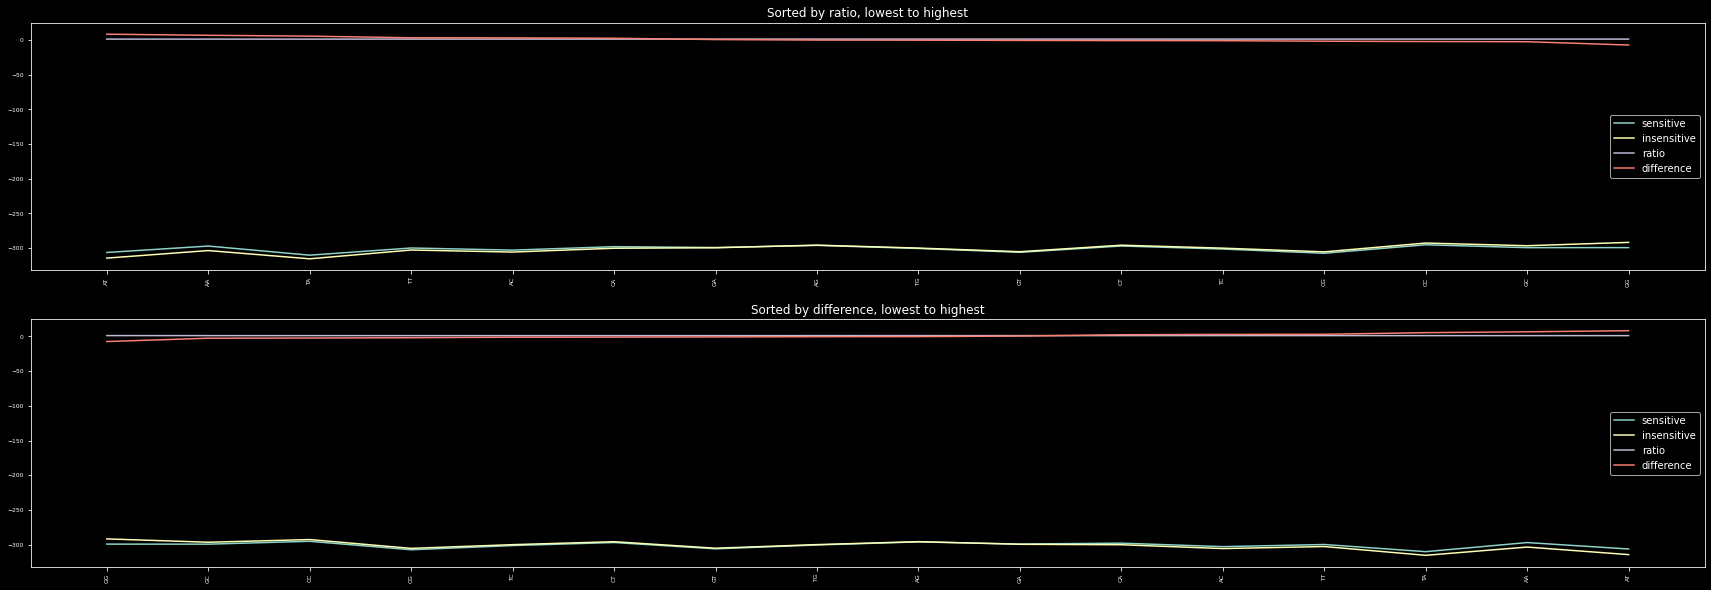

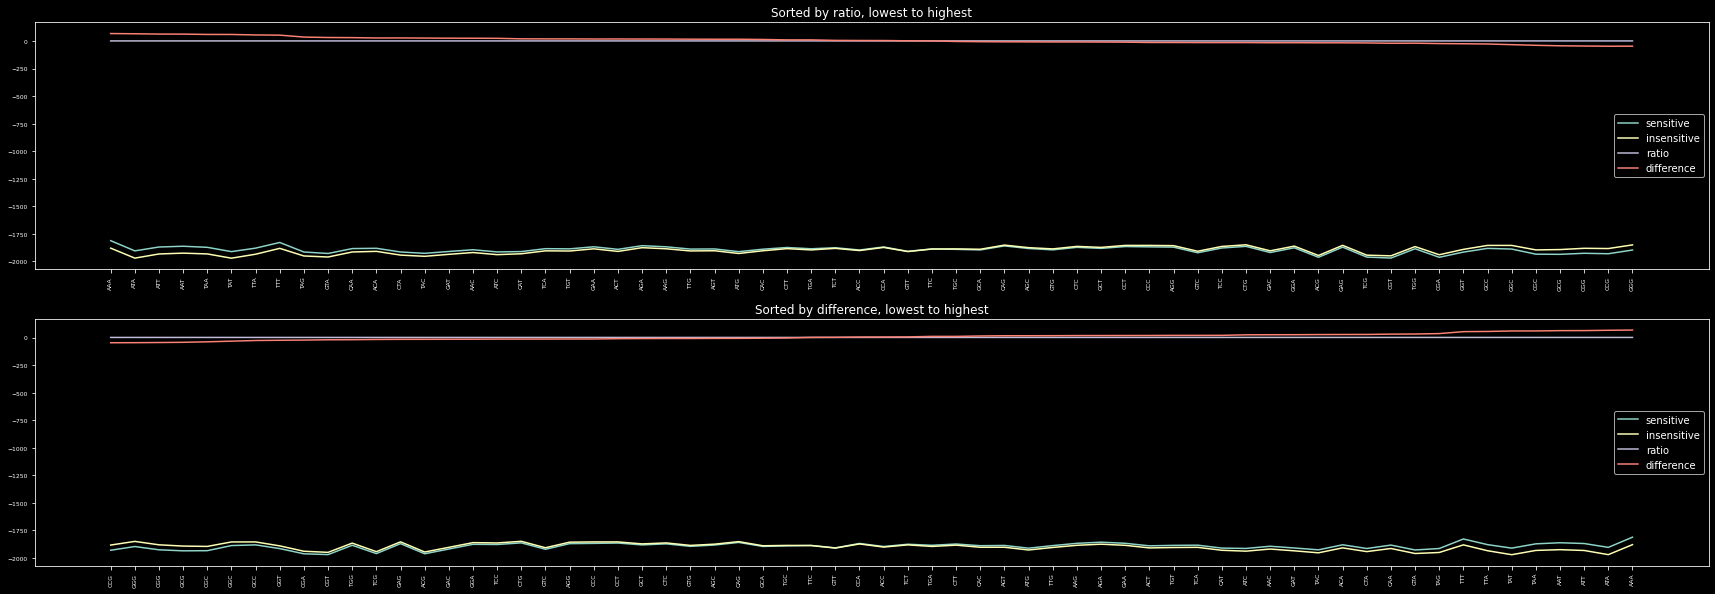

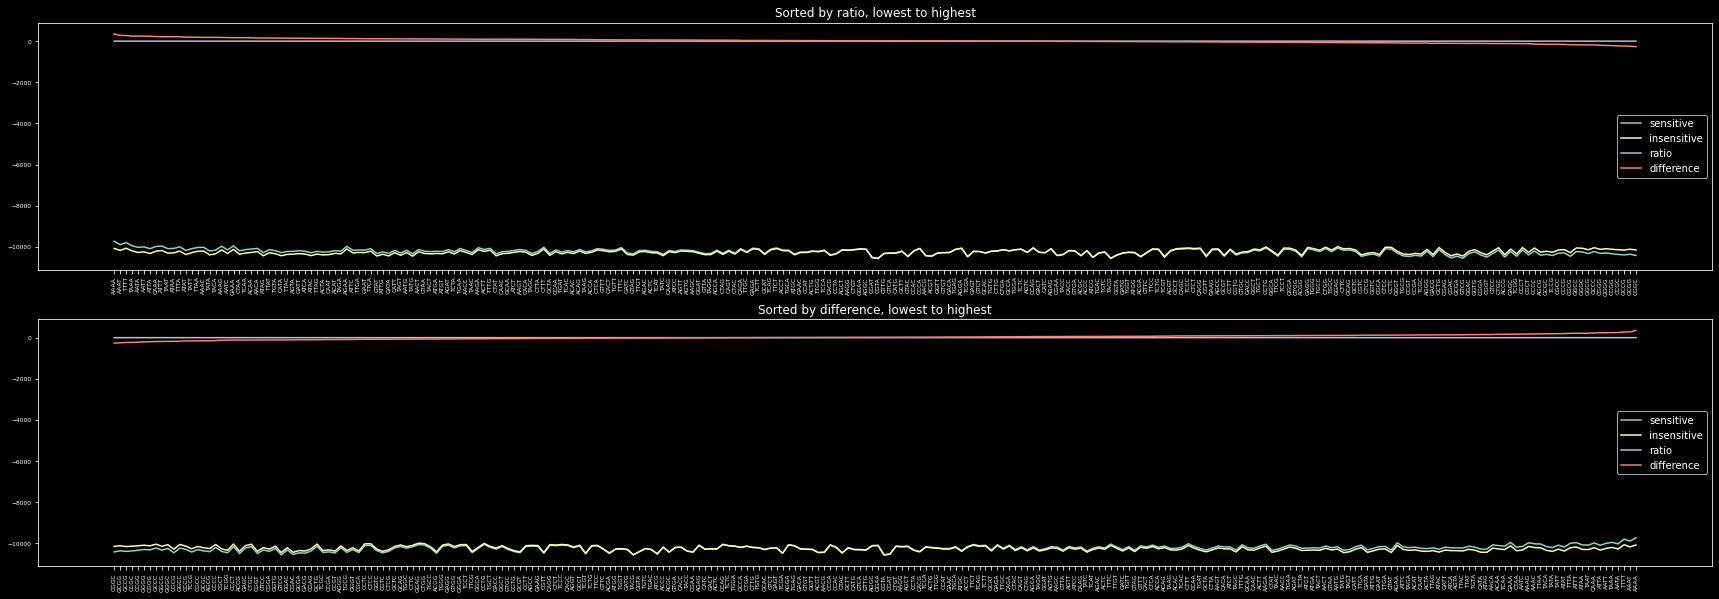

In [51]:
# Display results
display(results_df)

Seems like difference is a better discriminatory value.

### (Optional) _(4 pts)_ Building machine learning models
K-mer frequencies can be used as (simple) features for training machine learning models to
distinguish sensitive and insensitive transcripts. To this end, a sequence is represented by a
feature vector of k-mer counts.


Write code to generate kmer frequency feature vectors for all transcripts.

(a) The first step is to divide the data set into a training set and a test set for external
validation. From the transcripts, randomly select a set containing 80% of the data:
400 sensitive and insensitive transcripts each. This set will form the training data. The
remaining 20% of the transcripts form the external validation set. (see Figure 1)

In [ ]:
# Machine learning imports

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
# For a given k:

def kmer_dataframe(k:int=2) -> pd.DataFrame:
	"""For a given k, calculate log_odds_ratio and save it"""
	labels = []
	logs_odds = []

	# Open all files and get lists of sequences
	for file in [sensitive_file, insensitive_file]:
		with open(file) as f:
			label ,sequences  = zip(*fa.all_fasta_sequences(f))

			# Calculare freq
			for seq in sequences:
				logs_odds.append(log_odds_ratio(kmer_frequencies(insensitive[i],k), background))

			# Save info
			labels.extend([ lab.split(":")[0] for lab in  label])

	#Turn into dataframe
	kmers = [ "".join(kmer) for kmer in it.product(['A','G','T','C'], repeat=k) ]
	dataset = pd.DataFrame()
	dataset['label'] = labels
	for kmer in kmers:
		dataset[kmer] = [ result[kmer] for result in logs_odds ]
	return dataset


In [ ]:
dataset = kmer_dataframe()

In [ ]:
def split_data(dataset, test_size:float=0.20) -> tuple[list,list,list,list]:
	"""Splits dataset into two sets"""
	# Split into labels and features
	labels = dataset['label']
	features = dataset.drop(['label'],axis=1)

	# Create training (75%) and test (25%) sets
	features_train, features_test , labels_train , labels_test = train_test_split(features,labels,random_state=42, test_size =test_size)
	return features_train, features_test , labels_train , labels_test

In [ ]:
features_train, features_test , labels_train , labels_test= split_data(dataset)

(b) Using the training set, train Support Vector Machines with a linear kernel using grid
search for parameter C selecting C from ```[10**x for x in numpy.linspace(-2,2,9)]```,
i.e. ```[0.01,0.0316,0.1,0.316,1,3.16,10,31.6,100]``` for k = 2; 3; and 4. Use cross
validation with an appropriate number of n folds, e.g. n = 5. Which is the best C for
the different k's?


In [ ]:
def grid_search(params, classifier,features_train, labels_train):
	"""Grid search to find best parameters"""
	# Set up the grid search
	gs = GridSearchCV(classifier,params,n_jobs=-1,cv=5,scoring='accuracy')

	# Fit gs to training data
	gs_results = gs.fit(features_train, labels_train)

	# Find best fit
	print(f'Best score: {gs_results.best_score_}')
	print(f'Best parameters: \n{gs_results.best_params_}')

	# Get score
	print(f'\nScore: {gs.score(features_test, labels_test)}')

	return gs


### SVM : Grid Search

In [ ]:
# Parameter grid to search over using grid search
params={
	'C' :[10**x for x in np.linspace(-2,2,9)]
}

# Run grid search for k=[2,3,4]
for k in [2,3,4]:
	# Calculate dataset
	dataset = kmer_dataframe(k)
	# Split data
	features_train, features_test , labels_train , labels_test= split_data(dataset)
	# Grid Search
	print(f"\nK={k}")
	gs = grid_search(params, SVC(kernel='linear'),features_train, labels_train)

(c) Determine accuracy, precision and recall for the test set for the best three classifiers
corresponding to k = 2; 3; and 4.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def parameter_check(pred, labels_test):
    """Determines accuracy, precision, recall, f1 and aoc arc curve"""
    accuracy = accuracy_score(labels_test , pred)
    precision = precision_score(labels_test , pred, pos_label='sensitive')
    recall = recall_score(labels_test , pred, pos_label='sensitive')
    return { 'accuracy': accuracy, 'precision':precision, 'recall':recall }

In [ ]:
for k in [2,3,4]:
	# Calculate dataset
	dataset = kmer_dataframe(k)
	# Split data
	features_train, features_test , labels_train , labels_test= split_data(dataset)
	# Grid Search
	print(f"\nK={k}")
	gs= grid_search(params, SVC(kernel='linear'),features_train, labels_train)
	# Predict
	labels_preds = gs.predict(features_test)
	# Calculate results parameters
	best_par = parameter_check(labels_preds, labels_test)
	print(best_par)


(d) Repeat (b)-(c) for a Random Forest classifier. Here, you do not need to perform a
parameter search. Instead simply use the default parameters.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Run grid search for k=[2,3,4]
for k in [2,3,4]:
	# Calculate dataset
	dataset = kmer_dataframe(k)
	# Split data
	features_train, features_test , labels_train , labels_test= split_data(dataset)
	# Grid Search (empty dict for parameters, since we're using the defaults)
	print(f"\nK={k}")
	gs = grid_search({}, RandomForestClassifier(),features_train, labels_train) # Default params
	# Predict
	labels_preds = gs.predict(features_test)
	# Calculate results parameters
	best_par = parameter_check(labels_preds, labels_test)
	print(best_par)



Best algorithm would be RandomForestClassifier, for k = 3